### Integration with OpenCV DNN for Face Mask Detection

The comprehensive process of face mask detection is articulated in two integral steps: initially identifying faces within images and subsequently classifying each detected face based on the status of mask-wearing.

#### 1. **Integration with OpenCV DNN:**
- **Objective:** This segment of the notebook underscores the incorporation of the OpenCV DNN face detection model with the previously trained face mask detection model.
- **Procedure:** Faces within images are first pinpointed using OpenCV DNN, and each detected face is then classified by the face mask detection model into 'no mask', 'mask worn incorrectly', or 'with mask'.

#### 2. **Dataframe Preparation:**
- **Objective:** Initiate the process by formulating a compact dataframe that enumerates the total count of faces per image that meet the dimensional criteria for detection (15x15 pixels).
- **Utility:** This refined dataframe serves as a benchmark, enabling a comparative analysis of the effectiveness of the three distinct face detector models.

#### 3. **Operational Workflow:**
- **Step 1:** Employ OpenCV DNN to meticulously identify and locate faces within each image.
- **Step 2:** Utilize the face mask detection model to classify the detected faces based on mask-wearing status, ensuring a comprehensive analysis.

#### **Analytical Insights:**
- **Precision in Detection:** The integration with OpenCV DNN aims for meticulous face detection, laying a solid foundation for subsequent mask classification.
- **Comparative Analysis:** The formulated dataframe facilitates an in-depth comparison, offering insights into the relative efficacy of each face detection model.
- **Strategic Enhancement:** The insights derived from this comparative analysis are instrumental in informing future refinements and optimizations.

#### **Key Takeaways:**
- **Streamlined Integration:** The combination of OpenCV DNN’s face detection prowess and the face mask detection model’s classification accuracy ensures a well-rounded solution.
- **Data-Driven Insights:** The tailored dataframe enables a data-centric evaluation, fostering an informed selection of the optimal face detection model.
- **Evolutionary Adaptation:** Continuous assessments and refinements are embedded in the approach, ensuring the model’s alignment with emerging needs and enhancements.

In [1]:
# import the necessary packages
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from imutils import paths
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import cv2
import xml.etree.ElementTree as et
import pandas as pd

In [2]:
# create file paths for easy reference
image_path = pathlib.Path('../dataset/images')
annot_path = pathlib.Path('../dataset/annotations')
image_directories = sorted(glob.glob(os.path.join(image_path,"*.png")))
label_directories = sorted(glob.glob(os.path.join(annot_path, "*.xml")))

In [3]:
df = pd.read_pickle('image_df.pkl')
df.head()

,image,Dimensions,face_count,Object 1,Object 2,Object 3,Object 4,Object 5,Object 6,Object 7,...,Object 106,Object 107,Object 108,Object 109,Object 110,Object 111,Object 112,Object 113,Object 114,Object 115
0,0.png,"[512, 366]",3,"[without_mask, 79, 105, 109, 142]","[with_mask, 185, 100, 226, 144]","[without_mask, 325, 90, 360, 141]",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.png,"[400, 156]",9,"[with_mask, 321, 34, 354, 69]","[with_mask, 224, 38, 261, 73]","[with_mask, 299, 58, 315, 81]","[with_mask, 143, 74, 174, 115]","[with_mask, 74, 69, 95, 99]","[with_mask, 191, 67, 221, 93]","[with_mask, 21, 73, 44, 93]",...,0,0,0,0,0,0,0,0,0,0
2,2.png,"[400, 290]",4,"[with_mask, 68, 42, 105, 69]","[with_mask, 154, 47, 178, 74]","[with_mask, 238, 34, 262, 69]","[mask_weared_incorrect, 333, 31, 366, 65]",0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.png,"[400, 271]",9,"[with_mask, 52, 53, 73, 76]","[with_mask, 72, 53, 92, 75]","[with_mask, 112, 51, 120, 68]","[with_mask, 155, 60, 177, 83]","[with_mask, 189, 59, 210, 80]","[with_mask, 235, 57, 257, 78]","[with_mask, 289, 60, 309, 83]",...,0,0,0,0,0,0,0,0,0,0
4,4.png,"[301, 400]",1,"[with_mask, 70, 185, 176, 321]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Create a dataframe for comparisons 
classes = ["without_mask","mask_weared_incorrect","with_mask"]
face_list = []

# Extract data into respective label folders
for idx,image in enumerate(image_directories):
    
    im_name = image[62:]
    img  = cv2.imread(image)
    #scale to dimension
    X,Y = df["Dimensions"][idx]
    cv2.resize(img,(int(X),int(Y)))
    #find the face in each object
    face_count = 0
    for obj in df.columns[3:]:
        info = df[obj][idx]
        if info!=0:
            label = info[0]
            # first element of the "object" cell - replace label with the index from classes list
            info[0] = info[0].replace(str(label), str(classes.index(label)))
            info=[int(each) for each in info]
            face = img[info[2]:info[4],info[1]:info[3]]
            # Set a minimum size of 15 x 15 for face detection to improve model performance
            if((info[3]-info[1]>15) and (info[4]-info[2])>15):
                face_count += 1

    face_list.append([im_name, face_count])

print("Done!")

Done!


In [5]:
face_df = pd.DataFrame(face_list, columns=['image', 'face_count'])
face_df.head()

,image,face_count
0,,3
1,,9
2,,4
3,,7
4,,1


In [6]:
# save for use with other face detectors
face_df.to_pickle('face_df.pkl')

In [7]:
# read in face detector and weights
prototxtPath = os.path.sep.join(['./opencv_face_detector/', "deploy.prototxt"])
weightsPath = os.path.sep.join(['./opencv_face_detector/',
                               "res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)
# load the face mask detector model
print("[INFO] loading face mask detector model...")
model = load_model('face_mask_detector.h5')

[INFO] loading face mask detector model...


In [8]:
# With help from: https://github.com/opencv/opencv/blob/master/modules/dnn/misc/face_detector_accuracy.py

detections = []

def detect(img, imageId, confidence_min):
    
    """This function uses the face detector to locate faces in an image at a given confidence minimum.
       Predictions are made using the face mask detector model. Saves image name, label info, and 
       bounding box dimensions to a list for dataframe conversion when looped over, and will 
       produce an image with predictions if run independently."""
    
    image = cv2.imread(img)
    (h, w) = image.shape[:2]
    # blob takes in the image, scale factor, output size, and RGB means for subtraction.
    # ImageNet means are used as the default. 
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
    (104.0, 177.0, 123.0))
    net.setInput(blob)
    out = net.forward()

    for i in range(out.shape[2]):
        confidence = out[0, 0, i, 2]
        if confidence >= confidence_min:
            box = out[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            # ensure the bounding boxes fall within the dimensions of the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            
            # extract the face ROI, convert it from BGR to RGB channel, resize, and preprocess
            face = image[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)
            # pass the face through the model to determine class
            mask_weared_incorrect, with_mask, without_mask = model.predict(face)[0]
            # determine the class label and color we'll use to draw the bounding box and text
            if max([mask_weared_incorrect, with_mask, without_mask]) == with_mask:
                label = 'with_mask'
                color = (0, 255, 0)
            elif max([mask_weared_incorrect, with_mask, without_mask]) == without_mask:
                label = 'without_mask'
                color = (0, 0, 255)
            else:
                label = 'mask_worn_incorrectly'
                color = (255, 0, 0)
            # include the probability in the label
            label = "{}: {:.2f}%".format(label, max([mask_weared_incorrect, with_mask, without_mask]) * 100)
            # display the label and bounding box rectangle on the output frame
            cv2.putText(image, label, (startX, startY - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

            detections.append([img[62:], label, color, startX, startY, endX, endY])
            
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
            plt.grid(None)

1/1 [==============================] - 0s 45ms/step


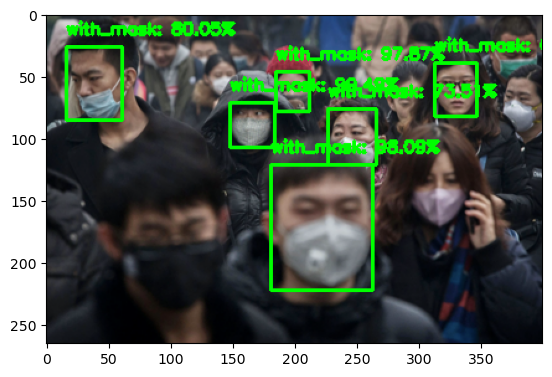

In [12]:
# test on one image
detect('../dataset/images/647.png', 165, 0.5)

1/1 [==============================] - 0s 64ms/step
error with image ..\dataset\images\446.png
1/1 [==============================] - 0s 54ms/step
error with image ..\dataset\images\811.png
1/1 [==============================] - 0s 51ms/step


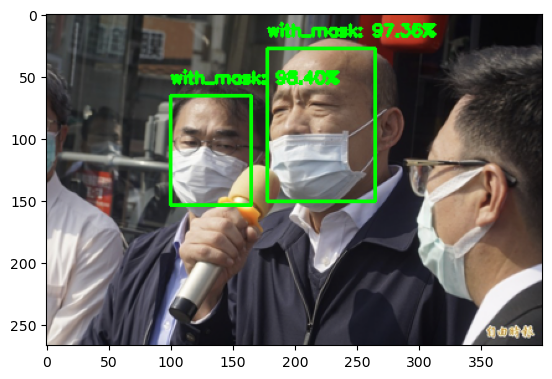

In [13]:
detections = []
for idx,image in enumerate(image_directories):
    
    imageId = idx
    try:
        detect(image, imageId, 0.3)
    except:
        print(f'error with image {image}')

In [14]:
len(detections)

1662

In [15]:
detections_df = pd.DataFrame(detections, columns=['image', 'label', 'color', 'startX', 'startY', 'endX', 'endY'])

In [16]:
detections_df.head()

,image,label,color,startX,startY,endX,endY
0,,without_mask: 94.58%,"(0, 0, 255)",322,78,362,143
1,,without_mask: 59.11%,"(0, 0, 255)",75,101,117,139
2,,with_mask: 93.52%,"(0, 255, 0)",76,45,111,92
3,,with_mask: 98.90%,"(0, 255, 0)",223,27,259,71
4,,with_mask: 99.59%,"(0, 255, 0)",319,26,352,67


In [17]:
detection_count = pd.DataFrame(detections_df.groupby('image')['label'].count())

In [18]:
face_detection_count_df = pd.merge(face_df, detection_count, on='image', how = 'left')

In [19]:
face_detection_count_df.columns = ['image', 'face_count', 'detected']
face_detection_count_df.fillna(0, inplace=True)
face_detection_count_df['diff'] = face_detection_count_df['face_count'] - face_detection_count_df['detected']

In [20]:
face_detection_count_df.sort_values('diff', ascending=False)

,image,face_count,detected,diff
226,,31,1662,-1631
472,,28,1662,-1634
22,,26,1662,-1636
177,,24,1662,-1638
187,,21,1662,-1641
...,...,...,...,...
726,,0,1662,-1662
114,,0,1662,-1662
637,,0,1662,-1662
360,,0,1662,-1662


In [21]:
face_detection_count_df[face_detection_count_df['diff'] > 0].sum()

image         0
face_count    0
detected      0
diff          0
dtype: object

In [22]:
face_detection_count_df[face_detection_count_df['diff'] < 0].sum()

image                 
face_count        2800
detected       1417686
diff          -1414886
dtype: object